In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from PIL import Image
from transformers import AutoImageProcessor, ViTModel

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import BertModel, BertTokenizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

torch.manual_seed(13)
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
text_encoder = BertModel.from_pretrained('bert-base-uncased')
text_encoder = text_encoder.to(device)

/home1/zhuyixin/.conda/envs/ml3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /home1/zhuyixin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home1/zhuyixin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Current Long Text

In [2]:
import os

# Define your class labels and associated file paths
classes = ['CC', 'EC', 'LGSC', 'HGSC', 'MC']
files = ['../textLabelLong/CC.txt', '../textLabelLong/EC.txt', '../textLabelLong/LGSC.txt', '../textLabelLong/HGSC.txt', '../textLabelLong/MC.txt']

# Dictionary to hold the data
data = {cls: [] for cls in classes}

central_sentences = ['Clear cell carcinoma is noted for its clear cytoplasm due to high glycogen content, often seen in cells that form distinctive patterns such as tubulocystic and papillary structures. It\'s appearance involves cells projecting into cystic spaces, contributing to the tumor\'s distinctive morphology.', 
         'Endometrioid carcinoma often mirrors the cellular structure of the endometrium, with well-formed glands and occasional squamous cells, presenting a histological diversity from well to poorly differentiated forms. It can present with various architectural patterns, including solid, cystic, and villoglandular, frequently associated with areas of hemorrhage and necrosis.', 
         'LGSC is less aggressive and features slow-growing cells with relatively uniform nuclei and minimal atypia, organized into intricate papillary structures. Despite its lower mitotic rate, this subtype can still exhibit psammoma bodies, though they are less common than in high-grade serous carcinoma.', 
         'This subtype is distinguished by its aggressive growth pattern and high mitotic index, featuring densely packed cells with irregular nuclei and prominent nucleoli. HGSC often shows extensive papillary and solid architecture, and may include psammoma bodies which are calcified deposits within the tumor.',
         'Mucinous carcinoma is characterized by its production of mucus, with tumors typically showing large cysts lined by tall columnar epithelial cells with abundant intracellular mucin. The mucin-filled cells often resemble those found in the gastrointestinal tract, making the tumors bulky and multilocular with a mixture of cystic and solid areas.']

# Read data from files
for cls, file_path, central_sent in zip(classes, files, central_sentences):
    with open(file_path, 'r') as file:
        sentences = file.read().splitlines()
    data[cls].extend(sentences)
    data[cls].insert(0, central_sent)  # Inserting central sentence at the beginning

# Function to encode a list of texts
def encode_texts(texts):
    encoded_input = tokenizer(texts, padding='max_length', max_length=80, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = text_encoder(**encoded_input)
    return model_output.pooler_output

# Encode data
embeddings = {cls: encode_texts(sentences) for cls, sentences in data.items()}

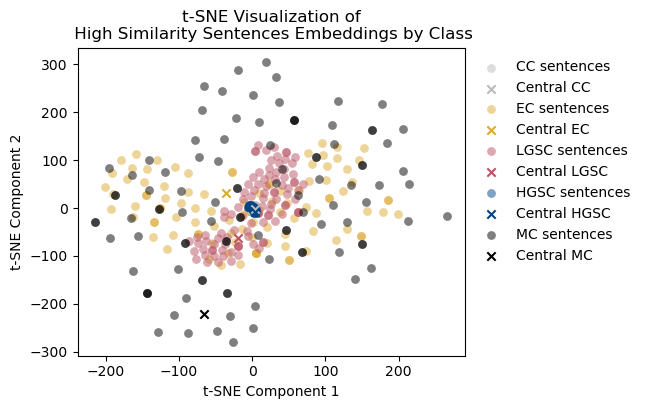

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensions and plot
tsne = TSNE(n_components=2, random_state=0, perplexity=30)  # Adjust perplexity as needed
colors = ['#BBBBBB', '#DDAA33', '#BB5566', '#004488', '#000000']

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply t-SNE to embeddings
    tsne_results = tsne.fit_transform(embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(tsne_results[1:, 0], tsne_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, linewidth=0, zorder=0)
    # Plot the central sentence with a different marker
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('t-SNE Visualization of\n High Similarity Sentences Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  
plt.savefig('../Report_Fig/Fig_2/tsne.high_similarity.png', format="png", dpi=300,bbox_inches='tight')

plt.show()


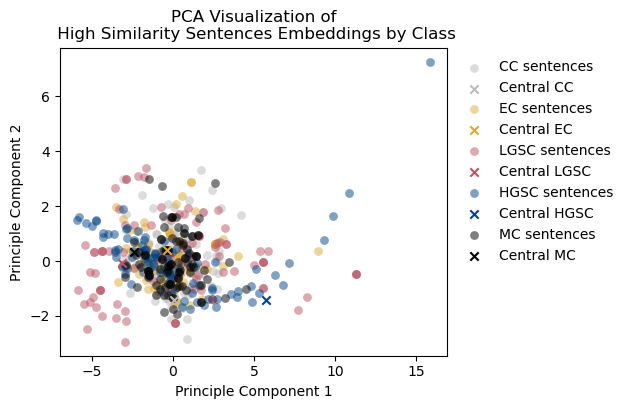

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components
colors = ['#BBBBBB', '#DDAA33', '#BB5566', '#004488', '#000000']

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply PCA to embeddings
    pca_results = pca.fit_transform(embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(pca_results[1:, 0], pca_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, linewidth=0, zorder=0)
    # Plot the central sentence with a different marker
    plt.scatter(pca_results[0, 0], pca_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('PCA Visualization of\n High Similarity Sentences Embeddings by Class')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.savefig('../Report_Fig/Fig_2/pca.high_similarity.png', format="png", dpi=300, bbox_inches='tight')

plt.show()


## Current Short Text

In [6]:
import re
short_files = ['../textLabel/CC.txt', '../textLabel/EC.txt', '../textLabel/LGSC.txt', '../textLabel/HGSC.txt', '../textLabel/MC.txt']

# Dictionary to hold the data
short_data = {cls: [] for cls in classes}

short_central_sentences = ['This type of cells have cell cytoplasm that are see through, and often have clear cell boundaries', 
             'Cells exhibit a back-to-back glandular pattern', 
             'This type of cells have cells close to normal healthy cells, cells containing single nuclei, and alive cell', 
             'There are many cells that are often deformed in shape, and many cells with multiple nucleus, and tissues often present many dead cells',
             'This type of cells often have goblet cells, they are often goblet-like or cell-like']
# Read data from files
for cls, file_path, central_sent in zip(classes, short_files, short_central_sentences):
    with open(file_path, 'r') as file:
        sentences = file.read().splitlines()
        cleaned_sentences = []
        for sentence in sentences:
            sentence = re.sub(r'^\d+\.\s*', '', sentence)
            cleaned_sentences.append(sentence)
    short_data[cls].extend(cleaned_sentences)
    short_data[cls].insert(0, central_sent)  # Inserting central sentence at the beginning

# Function to encode a list of texts
def encode_texts(texts):
    encoded_input = tokenizer(texts, padding='max_length', max_length=80, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = text_encoder(**encoded_input)
    return model_output.pooler_output

# Encode data
short_embeddings = {cls: encode_texts(sentences) for cls, sentences in short_data.items()}

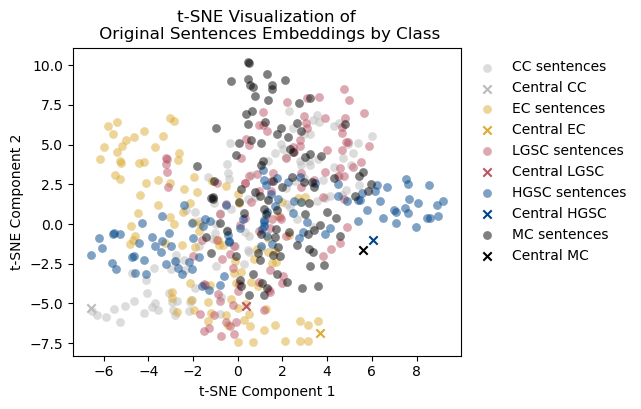

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensions and plot
tsne = TSNE(n_components=2, random_state=0, perplexity=30)  # Adjust perplexity as needed

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply t-SNE to embeddings
    short_tsne_results = tsne.fit_transform(short_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(short_tsne_results[1:, 0], short_tsne_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, linewidth=0, zorder=0)
    # Plot the central sentence with a different marker
    plt.scatter(short_tsne_results[0, 0], short_tsne_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('t-SNE Visualization of\n Original Sentences Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  
plt.savefig('../Report_Fig/Fig_2/tsne.original.png', format="png", dpi=300,bbox_inches='tight')

plt.show()


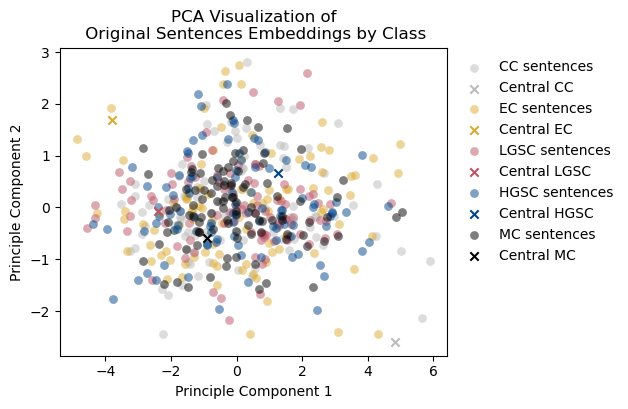

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components
colors = ['#BBBBBB', '#DDAA33', '#BB5566', '#004488', '#000000']

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply PCA to embeddings
    pca_results = pca.fit_transform(short_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(pca_results[1:, 0], pca_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, linewidth=0, zorder=0)
    # Plot the central sentence with a different marker
    plt.scatter(pca_results[0, 0], pca_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('PCA Visualization of\n Original Sentences Embeddings by Class')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.savefig('../Report_Fig/Fig_2/pca.original.png', format="png", dpi=300, bbox_inches='tight')

plt.show()


# Enhancing Diversity

### remove common keywords

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all texts into a single list for vectorization
all_texts = [sentence for class_sentences in data.values() for sentence in class_sentences]
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(all_texts)

# Get feature names to see which words have the highest TF-IDF scores in the corpus
feature_array = np.array(vectorizer.get_feature_names_out())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

# Print top 10 words
top_n = 10
top_keywords = feature_array[tfidf_sorting][:top_n]
top_keywords = np.append(top_keywords, "this")
top_keywords = np.append(top_keywords, "cell")
top_keywords = np.append(top_keywords, "type")
top_keywords = np.append(top_keywords, "of")
top_keywords = np.append(top_keywords, "cells")
top_keywords = np.append(top_keywords, "is")
top_keywords = np.append(top_keywords, "are")
top_keywords = np.append(top_keywords, "an")
top_keywords = np.append(top_keywords, "and")
top_keywords = np.append(top_keywords, "some")
top_keywords = np.append(top_keywords, "with")

print("Top keywords:", top_keywords)


Top keywords: ['variety' 'tumors' 'overflowing' 'involves' 'regions' 'produce'
 'resulting' 'resembling' 'columnar' 'tract' 'this' 'cell' 'type' 'of'
 'cells' 'is' 'are' 'an' 'and' 'some' 'with']


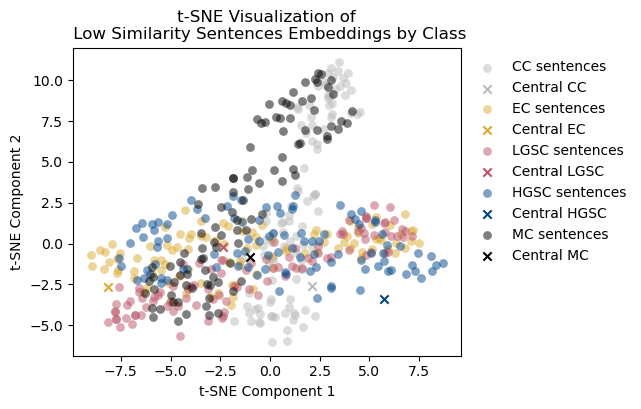

In [12]:
def remove_keywords(text, keywords):
    text = text.lower()
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word not in keywords]
    return ' '.join(filtered_words)  # Rejoin the words into a filtered sentence

filtered_data = {}
for cls, sentences in short_data.items():
    filtered_data[cls] = [remove_keywords(sentence, top_keywords) for sentence in sentences]

filtered_embeddings = {cls: encode_texts(sentences) for cls, sentences in filtered_data.items()}

# Reduce dimensions and plot
tsne = TSNE(n_components=2, random_state=0, perplexity=30)  # Adjust perplexity as needed

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply t-SNE to embeddings
    filtered_tsne_results = tsne.fit_transform(filtered_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(filtered_tsne_results[1:, 0], filtered_tsne_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, zorder=0, linewidth=0)
    # Plot the central sentence with a different marker
    plt.scatter(filtered_tsne_results[0, 0], filtered_tsne_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('t-SNE Visualization of\n Low Similarity Sentences Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  
plt.savefig('../Report_Fig/Fig_2/tsne.low_similarity.png', format="png", dpi=300,bbox_inches='tight')
plt.show()

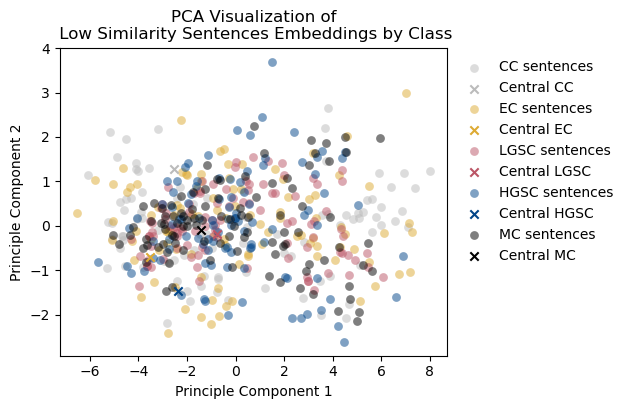

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components
colors = ['#BBBBBB', '#DDAA33', '#BB5566', '#004488', '#000000']

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply PCA to embeddings
    pca_results = pca.fit_transform(filtered_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(pca_results[1:, 0], pca_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=40, linewidth=0, zorder=0)
    # Plot the central sentence with a different marker
    plt.scatter(pca_results[0, 0], pca_results[0, 1], c=colors[i], label=f'Central {cls}', marker='x', zorder=1)

plt.title('PCA Visualization of\n Low Similarity Sentences Embeddings by Class')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.savefig('../Report_Fig/Fig_2/pca.low_similarity.png', format="png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
filter_centralText = ['have cytoplasm that see through, often have clear boundaries', 
            'exhibit a back-to-back glandular pattern', 
            'consists similar to normal cells, contain single nuclei, alive.',
            'there many that often deformed in shape, many multiple nucleus, tissues often present many dead',
            'these often exhibit goblet cells, usually taking on a goblet-like or cell-like appearance.']

### replace words with synonyms:

In [36]:
from nltk.corpus import wordnet

def synonyms(word):
    """ Fetch a list of synonyms for a given word """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def replace_with_synonyms(text):
    """ Replace words in the text with synonyms """
    words = text.split()
    new_words = []
    for word in words:
        syns = synonyms(word)
        if syns:
            # Replace with the first synonym
            new_words.append(syns[0])
        else:
            # If no synonyms, keep the original word
            new_words.append(word)
    return ' '.join(new_words)

# Assuming `data` is your dictionary of class texts
augmented_data = {}
for cls, sentences in filtered_data.items():
    augmented_sentences = [replace_with_synonyms(sentence) for sentence in sentences]
    augmented_data[cls] = augmented_sentences
augmented_embeddings = {cls: encode_texts(sentences) for cls, sentences in augmented_data.items()}

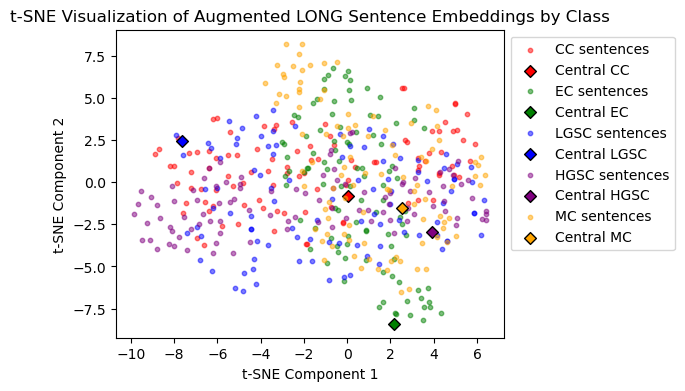

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensions and plot
tsne = TSNE(n_components=2, random_state=0, perplexity=30)  # Adjust perplexity as needed

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply t-SNE to embeddings
    augmented_tsne_results = tsne.fit_transform(augmented_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(augmented_tsne_results[1:, 0], augmented_tsne_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=10)
    # Plot the central sentence with a different marker
    plt.scatter(augmented_tsne_results[0, 0], augmented_tsne_results[0, 1], c=colors[i], edgecolors='black', label=f'Central {cls}', marker='D')

plt.title('t-SNE Visualization of Augmented LONG Sentence Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  
plt.show()


### enhance with key phrase:

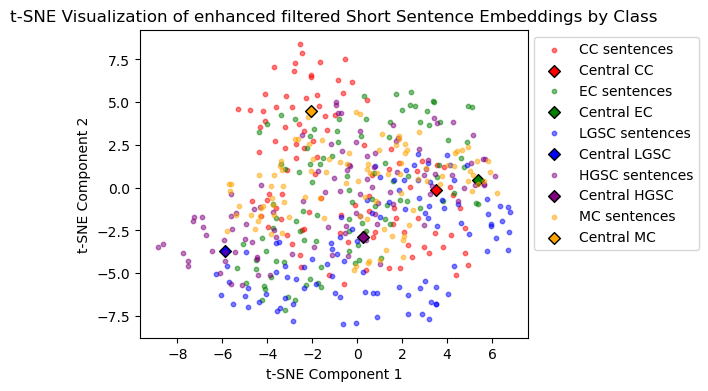

In [38]:
import random
import matplotlib.patches as patches

# Updated key phrases dictionary with more specific terms
key_phrases = {
    'CC': ['distinct cellular borders', 'clear', "see through"],
    'EC': ['endometrial glandular', 'squamous cell', 'estrogen-linked pathology'],
    'MC': ['mucin', 'colloid droplet accumulation', 'gastrointestinal localization'],
    'LGSC': ['indolent ovarian neoplasm', 'psammomatous calcifications', 'KRAS/BRAF mutations'],
    'HGSC': ['ubiquitous p53', 'aggressive nuclear atypia', 'STIC precursor lesion']
}

# Function to add key phrases randomly
def enhance_with_key_phrases(sentence, key_phrases):
    phrase = random.choice(key_phrases)
    if random.random() > 0.5:
        return sentence + ' ' + phrase
    else:
        return phrase + ' ' + sentence

# Apply the enhanced function to your data
enhanced_data = {}
for cls, sentences in augmented_data.items():
    enhanced_data[cls] = [enhance_with_key_phrases(sentence, key_phrases[cls]) for sentence in sentences]

enhanced_filtered_embeddings = {cls: encode_texts(sentences) for cls, sentences in enhanced_data.items()}

# Reduce dimensions and plot
tsne = TSNE(n_components=2, random_state=0, perplexity=30)  # Adjust perplexity as needed
colors = ['red', 'green', 'blue', 'purple', 'orange']

plt.figure(figsize=(5, 4))
for i, cls in enumerate(classes):
    # Apply t-SNE to embeddings
    enhanced_filtered_tsne_results = tsne.fit_transform(enhanced_filtered_embeddings[cls].numpy())
    
    # Plot all sentences for this class
    plt.scatter(enhanced_filtered_tsne_results[1:, 0], enhanced_filtered_tsne_results[1:, 1], c=colors[i], label=f'{cls} sentences', alpha=0.5, s=10)
    # Plot the central sentence with a different marker
    plt.scatter(enhanced_filtered_tsne_results[0, 0], enhanced_filtered_tsne_results[0, 1], c=colors[i], edgecolors='black', label=f'Central {cls}', marker='D')
    #x = enhanced_filtered_tsne_results[1:, 0]
    #y = enhanced_filtered_tsne_results[1:, 1]
    #center_x, center_y = x.mean(), y.mean()
    #std_x, std_y = x.std(), y.std()
    
    # Create an ellipse patch
    #ellipse = patches.Ellipse((center_x, center_y), 2*std_x, 2*std_y, edgecolor=colors[i], facecolor='none', lw=2)
    #plt.gca().add_patch(ellipse)

plt.title('t-SNE Visualization of enhanced filtered Short Sentence Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  
plt.show()

# Conclusion & output

In [50]:
!mkdir ../textLabelShortFilterted
!rm -rf ../textLabelShortFilterted/*

mkdir: cannot create directory '../textLabelShortFilterted': File exists


In [51]:
# Define base directory for files
base_directory = "../textLabelShortFilterted"  # Change this to your actual directory path

# File paths dictionary
file_paths = {
    'CC': f"{base_directory}/CC.txt",
    'EC': f"{base_directory}/EC.txt",
    'MC': f"{base_directory}/MC.txt",
    'LGSC': f"{base_directory}/LGSC.txt",
    'HGSC': f"{base_directory}/HGSC.txt"
}


In [52]:
for cls, sentences in filtered_data.items():
    with open(file_paths[cls], 'w') as file:
        for sentence in sentences:
            file.write(sentence + "\n")
